In [50]:
import numpy as np
import pandas as pd
from itertools import combinations
from math import comb, pow
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [51]:
bs = '\033[1m'
be = '\033[0m'

### train_test_split, cross_val_score, StandardScaler, MinMaxScaler

In [29]:
class model_selection:
    def __init__(self, shuffle = True):
        self.shuffle = shuffle
        
    def train_test_split(self, X, Y, test_ratio = 0.2):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.test_ratio = test_ratio
        self.n_samples = self.X.shape[0]
        self.n_test = int(self.n_samples * self.test_ratio)
        
        indices = np.arange(self.n_samples)
        if self.shuffle:
            np.random.shuffle(indices)
    
        test_indices = indices[:self.n_test]
        train_indices = indices[self.n_test:]
    
        X_train, X_test = self.X[train_indices, :], self.X[test_indices, :]
        Y_train, Y_test = self.Y[train_indices], self.Y[test_indices]
        
        return X_train, X_test, Y_train, Y_test

    def cross_val_score(self, kernel_type, X, Y, cv = 5):
        self.x = np.array(X)
        self.y = np.array(Y)
        self.model = KernelRidgeRegression(kernel_type)
        self.kernel_type = kernel_type
        self.samples = self.x.shape[0]
        fold_size = self.samples // cv
        indices = np.arange(self.samples)
        np.random.shuffle(indices)
        bs = '\033[1m'
        be = '\033[0m'
        mse_score = []
        mae_score = []
        r_sq_score = []

        print(f"\n{bs}{self.kernel_type}{be}\n")
        for fold in range(cv):
            if fold == cv-1:
                validation_indices = indices[fold*fold_size :]
                train_indices = np.concatenate([indices[:fold*fold_size], indices[(fold+1)*fold_size:]])
            else:
                validation_indices = indices[fold*fold_size : (fold+1)*fold_size]
                train_indices = np.concatenate([indices[:fold*fold_size], indices[(fold+1)*fold_size:]])
            
            x_train, x_val = self.x[train_indices], self.x[validation_indices]
            y_train, y_val = self.y[train_indices], self.y[validation_indices]
            
            model = self.model
            model.fit(x_train, y_train)
            prediction = model.predict(x_val)

            mse = mean_squared_error(prediction, y_val)
            mae = mean_absolute_error(prediction, y_val)
            r2 = r2_score(prediction, y_val)
            
            mse_score.append(mse)
            mae_score.append(mae)
            r_sq_score.append(r2)
            print(f"MSE : {round(mse, 3)}\t MAE : {round(mae, 3)}\t R2 : {round(r2, 3)}")
        return mse_score, mae_score, r2_score, 

class StandardScaler:
    def __init__(self):
        self.mean_ = None     #this '_' indicates that these variables are derived from the 
        self.scale_ = None    # data during the fitting process.

    def fit(self, X):
        X = np.array(X)
        self.mean_ = np.mean(X, axis = 0)
        self.scale_ = np.std(X, axis = 0)

    def transform(self, X):
        X = np.array(X)
        return (X-self.mean_)/(self.scale_)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class MinMaxScaler:
    def __init__(self, feature_range = (0, 1)):
        self.min_ = None
        self.max_ = None
        self.data_min_ = None
        self.data_max_ = None
        self.feature_range = feature_range

    def fit(self, X):
        X = np.array(X)
        self.data_min_ = np.min(X, axis = 0)
        self.data_max_ = np.max(X, axis = 0)
        self.min_, self.max_ = self.feature_range

    def transform(self, X):
        X = np.array(X)
        X_std = (X - self.data_min_) / (self.data_max_ - self.data_min_)
        X_scaled = X_std * (self.max_ - self.min_) + self.min_
        return X_scaled

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Kernel Functions

In [108]:
class kernel:
    def __init__(self):
        pass
        
    def anova_kernel(self, X, Y, p, upto_pth = True):
        '''
        One-dimensional kernel k, the ANOVA kernels are defined as follows
        '''
        def cal_k(x, y, ps):
            if ps == 0:
                return 1
            sum_k = 0
            for combination in combinations(range(len(x)), ps):
                product = 1
                for i in combination:
                    product *= x[i] * y[i]
                sum_k += product
            return sum_k
    
        '''
        n : length of the vector x
        Using, K(s) (x, y) = summ(i = 1 to n) (k(x(i), y(i)))**s
        '''
        def cal_ks(x, y, s):
            sum_i_to_n = 0
            for i in range(len(x)):
                product = (x[i] * y[i])**s
                sum_i_to_n += product
            return sum_i_to_n
    
        '''
        calculating the pth-kernel using Kp(x, y)
        only for pth order
        '''
        def kernel_p(x, y, p):
            sum_at_p = 0
            for s in range(1, p+1):
                sum_at_p += ((-1)**(s+1))*(cal_k(x, y, p-s))*(cal_ks(x, y, s))
            return sum_at_p/p  
            
        '''
        summation upto p order, including all the lower orders
        Using, K(x, y) = summ(i = 1 to p) Ki(x, y)
        Function, "kernel_p(x, y, p)" will be called for (i = 1 to p)
        '''
        def kernel_upto_p(x, y, P):
            sum_till_p = 0
            for p in range(1, P+1):
                sum_till_p += kernel_p(x, y, p)
            return sum_till_p
    
        #computing Kernel Matrix
        if upto_pth:
            K = np.zeros((X.shape[0], Y.shape[0]))     
            for i in range(X.shape[0]):
                for j in range(Y.shape[0]):
                    K[i, j] = kernel_upto_p(X[i], Y[j], p)
        else:
            K = np.zeros((X.shape[0], Y.shape[0]))     
            for i in range(X.shape[0]):
                for j in range(Y.shape[0]):
                    K[i, j] = kernel_p(X[i], Y[j], p)
            
        return K
    
    def spline_kernel(self, X, Y, d):
        '''
        kernel(x, y, d) : 
        x and y are vectors
        d : the parameter which defines the type of splines 
            if d = 1, linear splines
        calculates the summation from r = 0 to r = d
        Using, kd(x(i), y(i)) = first + second
        '''
        def kernels(x, y, d):
            sum = 0
            for r in range(d+1):
                seq = 2*d - r + 1
                first = (comb(d, r) / seq) * ((min(x, y)) ** seq) * ((abs(x - y)) ** r)
                second = ((x) ** r) * ((y) ** r)
                sum += first + second
            return sum
    
        '''
        The function : kernel(x, y, d) is for two elements of vectors (x(i), y(i)).
        So, in order to make is possible for N-dimensional case, 
        we multiply all the kd's 
        '''
        def splines(x, y, d):
            count = 0
            # product = 1
            sum = 0
            for i in range(len(x)):
                for j in range(len(y)):
                    count += 1
                    # product *= kernels(x[i], y[j], d)
                    sum += kernels(x[i], y[j], d)
            # if product < 0:
            #     product = abs(product) ** (1/count)
            #     return -product
            # return product ** (1/count*2)
            return sum/count
                    
        K = np.zeros((X.shape[0], Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                K[i, j] = splines(X[i], Y[j], d)
        return K
    
    def gaussian_kernel(self, X, Y, sigma = 1.0):
        X = np.array(X)
        Y = np.array(Y)
    
        if Y.ndim == 1:
            Y = Y.reshape(1, -1)
    
        K = np.zeros((X.shape[0], Y.shape[0]))
    
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                squared_distance = np.sum((X[i] - Y[j]) ** 2)
                K[i, j] = np.exp(-squared_distance / (2 * sigma ** 2))
                # print(f"K[{i}, {j}] = {K[i, j]}")
        
        return K

## KernelRidgeRegression

In [60]:
class KernelRidgeRegression:
    def __init__(self, **kwargs):
        self.kernel_type = kwargs.get('kernel_type', None)
        self.p = kwargs.get('p', 2)   # anova
        self.d = kwargs.get('d', 2)   # spline
        self.lambd = kwargs.get('lambd', 1.0)
        self.sigma = kwargs.get('sigma', 1.0)
        self.kernel = kernel()
        self.K_train = None
        self.K_test = None
    
    def fit(self, X, y):
        '''
        (K + a*I)*alpha = y
        => alpha = (pow((K + a*I), -1))*y
        Instead of doing the INVERSE computation, I have used 
        np.linalg.solve() : to solve the system of linear equations(more stable method), 
        '''
        self.X_train = X

        # calculating the Kernel Matrix on Training data
        if self.kernel_type == 'anova':
            self.K_train = self.kernel.anova_kernel(X, X, self.p, True)
        elif self.kernel_type == 'spline':
            self.K_train = self.kernel.spline_kernel(X, X, self.d)
        else:
            self.K_train = self.kernel.gaussian_kernel(X, X, self.sigma)

        # calculating alpha
        self.alpha = np.linalg.solve(self.K_train + self.lambd * np.eye(len(X)), y)
    
    def predict(self, X):
        if self.kernel_type == 'anova':
            self.K_test = self.kernel.anova_kernel(X, self.X_train, self.p, True)
        elif self.kernel_type == 'spline':
            self.K_test = self.kernel.spline_kernel(X, self.X_train, self.d)
        else:
            self.K_test = self.kernel.gaussian_kernel(X, self.X_train, self.sigma)
            
        return self.K_test.dot(self.alpha)

In [7]:
data = pd.read_csv('train.csv')
df = data.copy(deep = True)

In [8]:
df.describe()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,250.951952,3.360341,10.689189,11.293483,0.060060,0.557144,6.265619,68.226426,3.709934,9.633634,409.279279,18.448048,359.466096,12.515435,22.768769
std,147.859438,7.352272,22.674762,6.998123,0.237956,0.114955,0.703952,28.133344,1.981123,8.742174,170.841988,2.151821,86.584567,7.067781,9.173468
min,1.000000,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,6.000000,1.129600,1.000000,188.000000,12.600000,3.500000,1.730000,5.000000
25%,123.000000,0.078960,0.000000,5.130000,0.000000,0.453000,5.884000,45.400000,2.122400,4.000000,279.000000,17.400000,376.730000,7.180000,17.400000
50%,244.000000,0.261690,0.000000,9.900000,0.000000,0.538000,6.202000,76.700000,3.092300,5.000000,330.000000,19.000000,392.050000,10.970000,21.600000
75%,377.000000,3.678220,12.500000,18.100000,0.000000,0.631000,6.595000,93.800000,5.116700,24.000000,666.000000,20.200000,396.240000,16.420000,25.000000
max,506.000000,73.534100,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,21.200000,396.900000,37.970000,50.000000


In [9]:
df.drop(columns = ['ID', 'zn', 'chas', 'nox'], inplace = True)

In [30]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
split = model_selection()
x_train, x_test, y_train, y_test = split.train_test_split(X, Y, test_ratio=0.2)

scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.fit_transform(x_test)

In [33]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return (mse, mae, r2)

In [44]:
def plot(mse, mae, rsq, title):
    plt.figure(figsize = (8, 6))
    plt.plot(np.arange(len(mse)), mse, marker = 'o', linestyle = '-', color = 'b', label = 'MSE')
    plt.plot(np.arange(len(mae)), mae, marker = 'x', linestyle = '-', color = 'y', label = 'MAE')
    plt.plot(np.arange(len(rsq)), rsq, marker = '*', linestyle = '-', color = 'r', label = 'R2_score')
    plt.xlabel('Iterations')
    plt.ylabel('scores')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [63]:
def tuning_plot(params, kernel_type):
    mae = []
    mse = []
    rsq = []
    for i in range(1, params):
        print(f"Iteration {i}")
        if kernel_type in ['anova', 'spline']:
            model = KernelRidgeRegression(kernel_type = kernel_type, p = i, d = i)
        else:
            model = KernelRidgeRegression(kernel_type = kernel_type, sigma = 1 + (i/10))
        model.fit(x_train, y_train)
        prediction = model.predict(x_test)
        mae.append(mean_absolute_error(y_test, prediction))
        mse.append(mean_squared_error(y_test, prediction))
        rsq.append(r2_score(y_test, prediction))
    plot(mse, mae, rsq, kernel_type)
    return mae, mse, rsq

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29


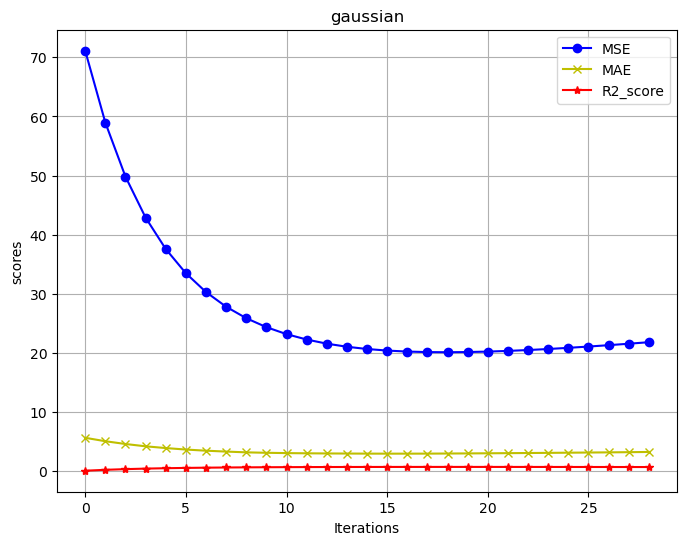

([5.669143613195151,
  5.090116578473926,
  4.6210608458097395,
  4.230747355521544,
  3.933519432053782,
  3.682848779915862,
  3.4889180459891467,
  3.3395151488301362,
  3.2092157999212514,
  3.1349379815160567,
  3.082186062763917,
  3.047477478450035,
  3.0239694552640546,
  3.007633624952764,
  2.9934667686056162,
  2.9876517923560946,
  2.988866065531752,
  2.9940270054027778,
  3.011332078786496,
  3.029544543401369,
  3.0504761181167708,
  3.073266812413673,
  3.0967306625636133,
  3.1218204275214205,
  3.1500595816933314,
  3.1785294841402196,
  3.207147563066795,
  3.2382278203104047,
  3.275485269296853],
 [71.1158558910881,
  58.96234066456621,
  49.826756517741714,
  42.89824506254736,
  37.592281898668936,
  33.49529704481773,
  30.312750038838363,
  27.830879746739956,
  25.891702313042277,
  24.37697306595153,
  23.197413431603003,
  22.28504960885558,
  21.587599262523412,
  21.064360026097507,
  20.68324300157193,
  20.41866199672515,
  20.25003454292529,
  20.160701

In [65]:
tuning_plot(30, kernel_type = 'gaussian')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


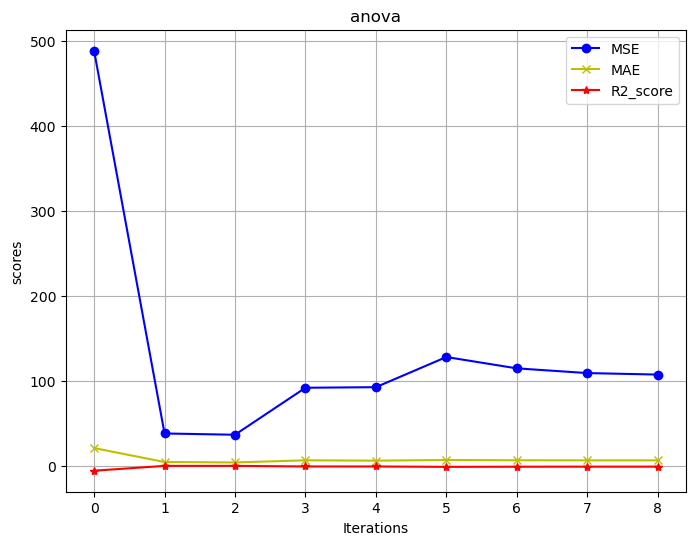

([21.443939393939424,
  5.073707794391457,
  4.548869294616866,
  7.063488634126667,
  6.678016101100804,
  7.44011739570391,
  7.119445402358254,
  7.025177451120172,
  7.01701809078163],
 [488.2368572115018,
  38.607778934603466,
  37.096029921610864,
  92.31483839647926,
  92.98439311455776,
  128.410739594166,
  115.09377733684781,
  109.55255083891281,
  107.79459857615186],
 [-5.159842926284597,
  0.5129047501080912,
  0.5319777396344969,
  -0.16469065349837853,
  -0.1731380941882763,
  -0.6200947844571347,
  -0.4520812587498666,
  -0.3821703449339944,
  -0.35999113078707223])

In [49]:
tuning_plot(10, kernel_type = 'anova')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


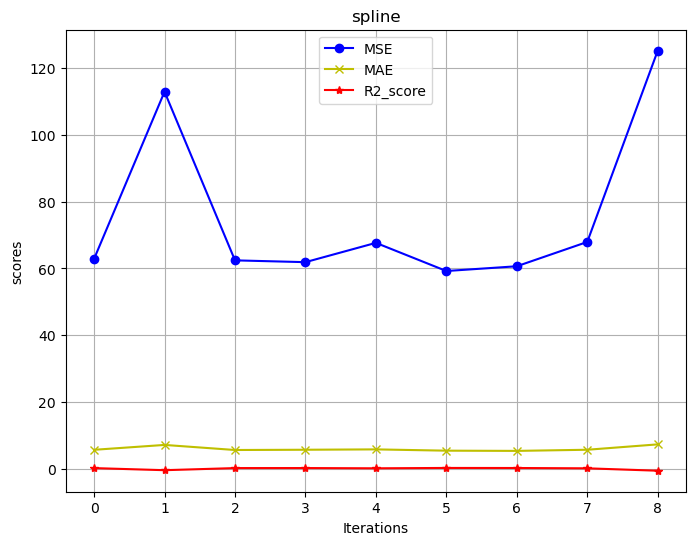

([5.685138343359909,
  7.144492329287791,
  5.624726667251801,
  5.7007044081307425,
  5.810284530251175,
  5.424422961597662,
  5.358698438144831,
  5.699208979169325,
  7.310926711068786],
 [62.85950435457117,
  112.90952470751103,
  62.41050423387706,
  61.87099210016117,
  67.6492460107782,
  59.2194372553485,
  60.64303307352471,
  67.92315736230744,
  125.18051949041629],
 [0.20693272634162097,
  -0.42452362374278607,
  0.21259753877129872,
  0.2194042964984707,
  0.14650292505987017,
  0.25285765241215474,
  0.2348968481407101,
  0.14304712102495376,
  -0.579340695202039])

In [100]:
tuning_plot(10, 'spline')

## Gaussian

In [111]:
model_gaussian = KernelRidgeRegression(kernel_type = 'gaussian', sigma = 2.8)
model_gaussian.fit(x_train, y_train)
gaussian_pred = model_gaussian.predict(x_test)

print(f"{bs}Gaussian Kernel{be}\n")
mse, mae, r2 = evaluate_model(gaussian_pred, y_test)
print(f"MSE : {round(mse, 3)}\t MAE : {round(mae, 3)}\t R2 : {round(r2, 3)}")

Gaussian Kernel

MSE : 20.161	 MAE : 2.994	 R2 : 0.616


## Multiplicative Kernels(Splines)

In [109]:
model_spline = KernelRidgeRegression(kernel_type = 'spline', d = 5)
model_spline.fit(x_train, y_train)
spline_pred = model_spline.predict(x_test)

print(f"{bs}Splines{be}\n")
mse, mae, r2 = evaluate_model(spline_pred, y_test)
print(f"MSE : {mse}\t MAE : {mae}\t R2 : {r2}")
# print(f"MSE : {round(mse, 3)}\t MAE : {round(mae, 3)}\t R2 : {round(r2, 3)}")

Splines

MSE : 67.6492460107782	 MAE : 5.810284530251175	 R2 : -0.9523641690218947


## ANOVA Kernel

In [112]:
model_anova = KernelRidgeRegression(kernel_type = 'anova', p = 2)
model_anova.fit(x_train, y_train)
anova_pred = model_anova.predict(x_test) 

print(f"{bs}ANOVA{be}\n")
mse, mae, r2 = evaluate_model(anova_pred, y_test)
print(f"MSE : {round(mse, 3)}\t MAE : {round(mae, 3)}\t R2 : {round(r2, 3)}")

ANOVA

MSE : 38.608	 MAE : 5.074	 R2 : 0.733
